# Подготовка рабочей среды
специально для gColab

In [ ]:
# Подключаем библиотеки для этого проекта:

import requests
# библиотека для работы с httml кодом (нам она нужна для работы с API)

import pandas as pd
# библиотека для работы базами данных

import time
# подклячаем библиотеку работы со времинем

from IPython.display import display
# функция для хорошо отбражения результата

In [ ]:
# Это код, чтобы почистить диспечер файлов твоей среды выполнения
!rm -R sample_data
# Удаляет директорию (папку) sample_data
!mkdir database
# Создает директорию (папку) datasets, где я храню базыданных

rm: cannot remove 'sample_data': No such file or directory
mkdir: cannot create directory ‘database’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# присоединить среду выполнения со своим гугл диском, другие пользователи доступа к нему иметь не будут
# но ты сможешь получить доступ к общей папке с проектом, которая будет у тебя на гугл диске
# созданные базыданных мы будем сохранять там, чтоб каждый раз из заново не строить

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Создание баз данных

## Создание первой базы данных

После многочасовых поисков и тестов подходящего API сервиса я выбрал Intrinio. Он предоставляет данные на конец дня, исторические данные, данные за день и в режиме реального времени, которые вы можете использовать для построения своего финансового продукта. Это позволяет загружать точные исторические рыночные данные за последние 5-50 лет. Важно отметить, что только акций на US биржах. Большим плюсом является то,что Intrinio в реализованы SDKS для python. Были также рассмотрены: apimoex, Marketstack, Finnhub, Barchart, IEX Cloud API.

In [ ]:
pip install intrinio-sdk

     |████████████████████████████████| 860kB 4.0MB/s 


Код ниже не запускать!!!

In [ ]:
import intrinio_sdk
from __future__ import print_function
import intrinio_sdk as intrinio
from intrinio_sdk.rest import ApiException

intrinio.ApiClient().set_api_key('OmFkOWYxMWIxYmViN2M0NzgyMzNiNzFmZjQ1ZTA4M2Vi')
intrinio.ApiClient().allow_retries(True)

identifier = 'AAPL'
tag = 'close_price'
frequency = 'daily'
type = ''
start_date = '2015-01-01'
end_date = ''
sort_order = 'desc'
page_size = 10000
next_page = ''


idfidentifier_list = pd.read_excel('/content/drive/MyDrive/Finance machine/Компании S&P 500 Index.xlsx')
# по идее если ты подключишь свой гугл драйв сюда и на гугл диске у тебя будет папка нашего проекта
# то путь к файлу будет таким же


df = list()
date = ['date']
response = intrinio.HistoricalDataApi().get_historical_data(identifier, tag, frequency=frequency, type=type, start_date=start_date, end_date=end_date, sort_order=sort_order, page_size=page_size, next_page=next_page)
for elem in response.historical_data:
    date.append(elem.date)
df.append(date)
print(123)

i = 0
idfidentifier_list = idfidentifier_list['Символ']
for identifier in idfidentifier_list:
    if i > 400:
        break
    i += 1
    try:
        response = intrinio.HistoricalDataApi().get_historical_data(identifier, tag, frequency=frequency, type=type, start_date=start_date, end_date=end_date, sort_order=sort_order, page_size=page_size, next_page=next_page)
    except:
        continue
    value = [identifier]
    for elem in response.historical_data:
        value.append(elem.value)
    value.append(identifier)
    df.append(value)
    print(i, identifier)

123


KeyError: ignored

In [ ]:
df = pd.DataFrame(df).transpose()
df = df.drop([1456, 1457, 1458, 1459, 1460, 1461, 1462], axis=0)
df = df.set_axis(df.loc[0], axis='columns')
df = df.set_index('date')
df = df.drop(index='date')
df.to_csv('/content/drive/MyDrive/Finance machine/Den_database.csv')
df.to_csv('/content/database/Den_database.csv')

In [ ]:
df

In [ ]:
import datetime
from datetime import date

current_date = date.today()

identifier = 'AAPL'
response = intrinio.HistoricalDataApi().get_historical_data(identifier, tag, frequency=frequency, type=type, start_date=start_date, end_date=end_date, sort_order=sort_order, page_size=page_size, next_page=next_page)
for elem in response.historical_data:
    a = elem.date
    print(isinstance(a, datetime.date))

## Новый подход к созданию базы данных

После тестов, было выяснено, что база данных полученная методом выше, не достаточна хороша. Поэтому было решено сделать все заново. В этот раз мы используем API tdameritrade. https://developer.tdameritrade.com

Узнал я об этом API из этой статьи https://smart-lab.ru/blog/586228.php

Чтобы понять код ниже достаточно посмотреть этот гайд: https://www.youtube.com/watch?v=qJ94sSyPGBw&ab_channel=SigmaCoding

Далее, давайте отправим первый запрос:

In [ ]:
endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format('AAPL')

# определяем аргументы в запросе
payload = {'apikey':'GLFGYLQBFI6GJ0DXCYWTW2OX9VILGOH6',
           'periodType':'', # тип периода указывать не нежно, если указываем период в endDate и startDate
           'frequencyType':'minute',
           'frequency':'1440',
           'period':'', # аналогичная причина, что и в 'periodType'
           'endDate':'1618698582000', # дата взята в дени написания этоя ячейки
           'startDate':'1617698582000',
           'needExtendedHoursData':'true'}

# отправяем запрос
content = requests.get(url = endpoint, params = payload)

# конвертируем в словарь
data = content.json()

Сейчас нам нужно понять как харнить полученные данные. Мы получаем данные ввиде словаря с 3 элементами. 1ый элемент – массив(list) содержащий информацию о свечке. 2ой элемент - строчка, тикет компании. 3ий - bool, обозначает пустой ли запрос.

In [ ]:
data['candles'][7338]

In [ ]:
data['symbol']

In [ ]:
data['empty']

Тикет - определяет компанию, это признак, который можно использовать как категориальный, но основная его ценность в резделении данных.

Далее рассмотрим данные свечки:

close - цена закрытия, то что мы хотим предсказывать

high - самая высокая цена за период свечки, может быть полезна, особенно если период свечки достаточно большой.

low - самая низкая цена за период свечки, может быть полезна, особенно если период свечки достаточно большой.

open - цена закрытия, то что мы хотим предсказывать, она должна почти совпадает с ценой закрытия предидущей свечки. Это мы сейчас и проверим:

In [ ]:
loss = 0
for i in range(len(data['candles']) - 1):
    loss += abs(data['candles'][i]['close'] - data['candles'][i + 1]['open'])
print(loss)

За двухдневний период разница оказалось давольно большой.

Давайте проверим две случайные соседние свечки:

In [ ]:
print(data['candles'][100]['close'])
print(data['candles'][101]['open'])

Видимо, дело в том, что последняя сделка в один период времени, не является первой во второй период, теперь давайте посмотрим на результат, без модуля:

In [ ]:
loss = 0
for i in range(len(data['candles']) - 1):
    loss += data['candles'][i]['close'] - data['candles'][i + 1]['open']
print(loss)

Как видно разница не очень большая. Храния оба эти признака мы просто будем хранить данные о двух соседних сделках, думаю лучше хранить информацию в среднем о периоде. Или только один из этих признаков. Но для начала, не будем задумываться об оптимизации, и сохраним оба.

volume - объем сделок в этот период, один из ключевых факторов.

datetime - время в Epoch ситстеме в милисекундах, важны признак, которы мы хотим хранить.

Теперь когда мы знаем, с чем имеем дело, давайте подумаем в каком виде мы хотим хранить наши данные. Для начала, нам подойдет простая таблица.

In [ ]:
df = pd.DataFrame(data['candles'])
df = pd.concat([df, pd.DataFrame(data)], axis = 1)
df = df.drop(columns='candles')

In [ ]:
# получаем список тикеров компаний, входящий в snp 500
idfidentifier_list = pd.read_excel('/content/drive/MyDrive/Finance machine/Компании S&P 500 Index.xlsx')

In [ ]:
# Собираем информацию о весх интересующих нас компаниях

# создаем нашу будующую базу данных

payload = {'apikey':'GLFGYLQBFI6GJ0DXCYWTW2OX9VILGOH6',
           'periodType':'', # тип периода указывать не нежно, если указываем период в endDate и startDate
           'frequencyType':'minute',
           'frequency':'30',
           'period':'', # аналогичная причина, что и в 'periodType'
           'endDate':'1618698582000', # дата взята в дени написания этоя ячейки
           'startDate':'1617698582000',
           'needExtendedHoursData':'true'}

counter = 0
for i in idfidentifier_list['Символ']:
    endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(i)
    content = requests.get(url = endpoint, params = payload)
    data = content.json()
    df_temp = pd.DataFrame(data['candles'])
    df_temp = pd.concat([df_temp, pd.DataFrame(data)], axis = 1)
    df_temp = df_temp.drop(columns='candles')
    df = pd.concat([df, df_temp])
    counter += 1
    if counter == 120: # ограничение в 120 запросов в минуту установлено используемым API
        time.sleep(60)
        counter = 0

In [ ]:
df.to_csv('/content/drive/MyDrive/Finance machine/Den_database.csv', index=False)

## База данных за последние 9 месяцев с периодом 15 минут

In [ ]:
# получаем список тикеров компаний, входящий в snp 500
idfidentifier_list = pd.read_excel('/content/drive/MyDrive/Finance machine/Компании S&P 500 Index.xlsx')

In [ ]:
# Собираем информацию о весх интересующих нас компаниях

# создаем нашу будующую базу данных

df = pd.DataFrame()

payload = {'apikey':'GLFGYLQBFI6GJ0DXCYWTW2OX9VILGOH6',
           'periodType':'', # тип периода указывать не нужно, если указываем период в endDate и startDate
           'frequencyType':'minute',
           'frequency':'15',
           'period':'', # аналогичная причина, что и в 'periodType'
           'endDate':'1619827200000', # 1 мая 2021
           'startDate':'1598918400000', # 1 сентября 2020
           'needExtendedHoursData':'true'}

counter = 0
for i in idfidentifier_list['Symbol']:
    endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(i)
    content = requests.get(url = endpoint, params = payload)
    data = content.json()
    df_temp = pd.DataFrame(data['candles'])
    df_temp = pd.concat([df_temp, pd.DataFrame(data)], axis = 1)
    df_temp = df_temp.drop(columns='candles')
    df = pd.concat([df, df_temp])
    counter += 1
    print(i)
    if counter == 120: # ограничение в 120 запросов в минуту установлено используемым API
        time.sleep(60)
        counter = 0

In [ ]:
df.datetime = df.datetime // 1000
df.to_csv('/content/drive/MyDrive/Finance machine/9month_15min.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Finance machine/9month_15min.csv')

In [ ]:
df

## База данных за последние 5 лет с периодом 1 день

---



In [ ]:
# получаем список тикеров компаний, входящий в snp 500
idfidentifier_list = pd.read_excel('/content/drive/MyDrive/Finance machine/Компании S&P 500 Index.xlsx')

In [ ]:
# Собираем информацию о весх интересующих нас компаниях

# создаем нашу будующую базу данных

df = pd.DataFrame()

payload = {'apikey':'GLFGYLQBFI6GJ0DXCYWTW2OX9VILGOH6',
           'periodType':'year', # тип периода указывать не нужно, если указываем период в endDate и startDate
           'frequencyType':'daily',
           'frequency':'1',
           'period':'1', # аналогичная причина, что и в 'periodType'
           'endDate':'1619827200000', # 1 мая 2021
           'startDate':'1462060800000', # 1 мая 2016
           'needExtendedHoursData':'true'}

counter = 0
for i in idfidentifier_list['Symbol']:
    endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(i)
    content = requests.get(url = endpoint, params = payload)
    data = content.json()
    df_temp = pd.DataFrame(data['candles'])
    df_temp = pd.concat([df_temp, pd.DataFrame(data)], axis = 1)
    df_temp = df_temp.drop(columns='candles')
    df = pd.concat([df, df_temp])
    counter += 1
    print(i)
    if counter == 120: # ограничение в 120 запросов в минуту установлено используемым API
        time.sleep(60)
        counter = 0

In [ ]:
df.datetime = df.datetime // 1000
df.to_csv('/content/drive/MyDrive/Finance machine/5year_1day.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Finance machine/5year_1day.csv')

In [ ]:
df

# Реализация MLP

**MLP**

Многослойный персептрон (MLP) - это класс прямой искусственной нейронной сети.

MLP состоит по крайней мере из трех слоев узлов: входного слоя, скрытого слоя и выходного слоя. За исключением входных узлов, каждый узел представляет собой нейрон, который использует нелинейную функцию активации. MLP использует метод контролируемого обучения под названием backpropagation для обучения. Его множественные слои и нелинейная активация отличают MLP от линейного персептрона. Он может различать данные, которые не являются линейно разделимыми.

## Подготовка данных

**и как MLP будет выглядеть у нас**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Finance machine/9month_15min.csv')
idfidentifier_list = pd.read_excel('/content/drive/MyDrive/Finance machine/Компании S&P 500 Index.xlsx')
# df = pd.read_csv('/content/drive/MyDrive/Finance machine/5year_1day.csv')

In [ ]:
!pip install mplfinance
import mplfinance as mpf
import numpy as np

     |████████████████████████████████| 71kB 9.4MB/s 


In [ ]:
df.datetime = pd.to_datetime(df["datetime"], unit = 's')

In [ ]:
rslt_df = df.set_index(df.datetime)
rslt_df = rslt_df.drop(columns='datetime')
rslt_df = rslt_df[rslt_df['symbol'] == "MMM"]

/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


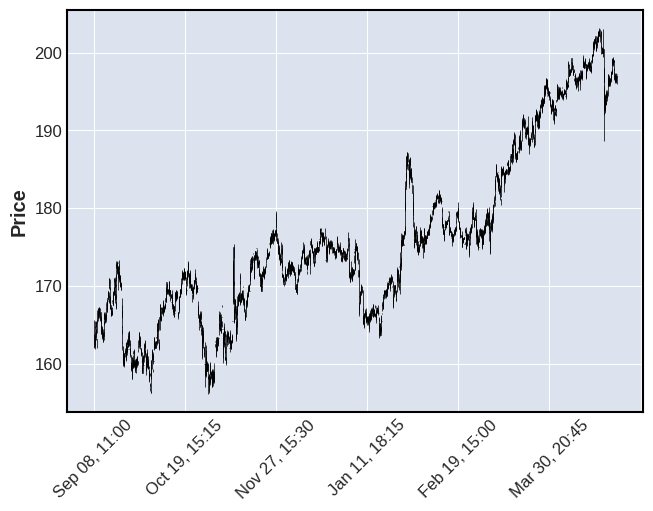

In [ ]:
mpf.plot(rslt_df)

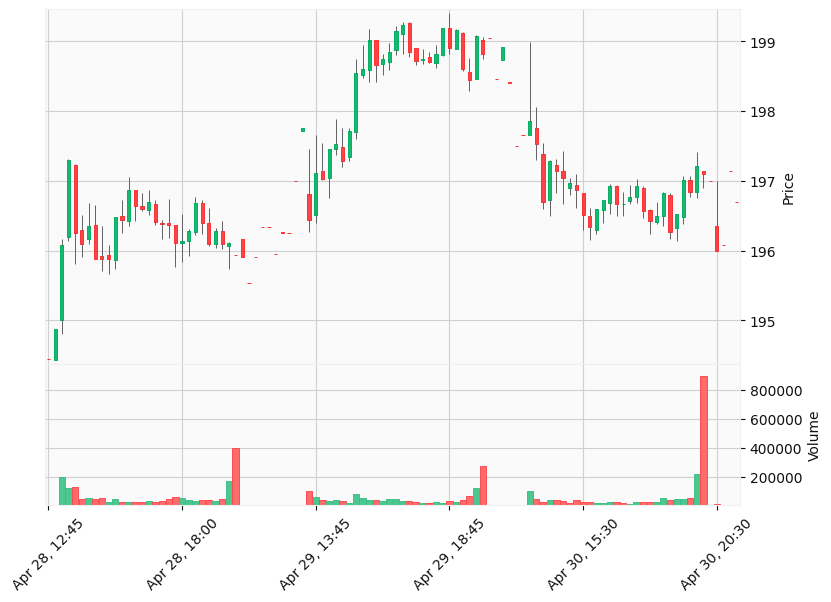

In [ ]:
mpf.plot(rslt_df['2021-4-28':'2021-5'], # за последние 3 дня
         type='candle',
         volume=True,
         style="yahoo",
         tight_layout=True)

Чтобы обучить mlp, нам нужно придумать какие параметры она будет получать и что она будет предсказывать. Моя первая идея: в качестве параметров она будет получать все данные за последний день с интервалом 15 минут, от 1 дня до недели с инервалом час, и от недели до 3 месяцев интервалом в день. А предсказывать будем стоимость через 1 день.

Для этого давайте выберем 100 раз случайное время, из промежутка [1 декабря - 29 апреля] для каждого тикета. Также при выборе времени убедимся, что она находится в промежутке торгов акциями. Это можно определить по объему. Таким образов у нас получится выборка из 50 500 объектов.

для начала проверим что для всех тикетов у нас есть данные по каждому промежутку:

In [ ]:
rslt_df = df.set_index(df.datetime)
rslt_df = rslt_df.drop(columns='datetime')

new_df = rslt_df.loc['2020-12-1':'2021-4-29']
b = new_df[new_df['symbol'] == "MMM"].shape[0]
for ticket in idfidentifier_list['Symbol']:
    new_df = df[df['symbol'] == ticket]
    a = new_df.shape[0]
    if a != b:
        print(a)
        break
    b = a

Это не так для 15 минутной базы данных, утверждение можно подтвердить, просто посмотря на количество данных по каждому тикету

In [ ]:
i = 0
for ticket in idfidentifier_list['Symbol']:
    if i == 10:
        break
    print(df[df['symbol'] == ticket].shape[0])
    i+= 1

In [ ]:
# тут я тестил, то что мне пригодится далее
# тут я получаю индекс первого элемента принадлежащего "2020-12-1" для всех тикетов
a = df.index[df['datetime']  >= "2020-12-1"]
b = []
for ticket in idfidentifier_list['Symbol']:
    temp = df.index[df['symbol']  == ticket]
    b.append(temp.intersection(a)[0])

In [ ]:
# проверка
print(len(b))
for i in range(5):
    print(df.loc[b[i], 'datetime'])

In [ ]:
df.head()

Для начала сделаем парсинг данных таким образом: прошлый день по 15 минут и последний элемент. это стоимость при открытии на следующий день

In [ ]:
# получение выборки (парсинг)

counter = 0
selection = list(range(486))
selection = pd.DataFrame(columns=selection)
for ticket in idfidentifier_list['Symbol']:
    a = 0
    new_df = df[df['symbol'] == ticket]
    for i in range(100):
        if a == 0:
            a = new_df[new_df['datetime']  >= "2020-12-1"].shape[0]
        chosen_idx = np.random.choice(a) # выберает случайный индекс из индексов элементов принадлежащих промежутку [1 декабря - 29 апреля]
        elem = df.iloc[b[counter] + chosen_idx, 0:5].to_list() # выбранный элемент   
        for j in range(24*4):
            elem = elem + df.iloc[b[counter] + chosen_idx - j - 1, 0:5].to_list() # добавляем историческая информация за последний день
        elem.append(df.iloc[b[counter] + chosen_idx + 24*4, 0]) # добавляем стоимость тикета через день
        selection.loc[selection.shape[0]] = elem
    print(str(counter + 1) + " из 505")
    counter += 1

selection

In [ ]:
selection.to_csv('/content/drive/MyDrive/Finance machine/MLP_selection.csv', index=False)

In [ ]:
selection = pd.read_csv('/content/drive/MyDrive/Finance machine/MLP_selection.csv')

In [ ]:
selection

## Реализация MLP

Для удобства я выбрал писать млп использую библиотке tensorflow. Она специально написана работы в гугл колаб.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
print(tf.version)

#with tf.compat.v1.Session() as sess: # seess – nимя твоей сессии, создает сессию используя дефолтный граф
#    tensor.elav() # tensor – имя твоего тензора

import numpy as np
import matplotlib.pyplot as plt
#!pip install -q sklearn

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
# задача классификации
selection = pd.read_csv('/content/drive/MyDrive/Finance machine/MLP_selection.csv')
#display(selection.head(3))
selection['485'] = selection['485'] - selection['0']
#display(selection.head(3))
selection['485'] = np.sign(selection['485'])
#selection.head(3)

In [ ]:
selection.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
481    0
482    0
483    0
484    0
485    0
Length: 486, dtype: int64

In [ ]:
# разделяем данные на обучающие и на тестирующие
x_train = selection.loc[0:int(selection.shape[0]*2/3)]
x_test = selection.loc[int(selection.shape[0]*2/3 + 1):]
print(x_train.shape[0])
print(x_test.shape[0])
print(selection.shape[0])
print(x_train.shape[0] + x_test.shape[0])

33623
16811
50434
50434


In [ ]:
# разделяем данные на признаки и значения
class_names = ["will grow", "will fall"]

y_train = x_train["485"]
x_train = x_train.drop(columns="485")
y_test = x_test["485"]
x_test = x_test.drop(columns="485")

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 2/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 3/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 4/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 5/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 6/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 7/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 8/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 9/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013
Epoch 10/10
1051/1051 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0013


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print("Test accuracy", test_acc)

526/526 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0018
Test accuracy 0.0018440306885167956


In [ ]:
# Чтобы не нагружать ram память, так как наш датасет слишком большой, мы будем подавать данные в виде бача

# создание imput_function
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32): # shuffle = True по умолчанию
    def input_function():
        df = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # creates tf.data.Dataset object with data and its label
        if shuffle:
            ds = ds.shuffle(1000) # случайный порядок данных
        ds = ds.batch(batch_size).repeat(num_epochs) # разделяет датасет на батчи размером 32 и повторяет это столько раз сколько у нас эпох
        return ds # возращает батч из датасета
    return input_function # возращает объект-функцию

train_input_fn = make_input_fn(x_train, y_train)
evel_input_fn = make_input_fn(x_test, y_test, num_epochs=1, shuffle=False)

Обучения MLP

*Результат*

# Реализация LSTM

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

LSTM - особая разновидность архитектуры рекуррентных нейронных сетей, способная к обучению долговременным зависимостям. Например, когда простая реккурентная нейросеть считывает что-то из данных, она выводит эту информацию на каждом временном шаге и постепенно забывает ее каждый раз. В LSTM может переносить информацию гораздо дольше и выводить ее только в определнные временные шаги. LSTM имеет множество преимуществ по сравнению с простой реккурентной нейронной сетью. LSTM-сеть хорошо приспособлена к обучению на задачах классификации, обработки и прогнозирования временных рядов

In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/Finance machine/9month_15min.csv')

Нормализация данных.

1) Разбиваем данные на тестовые и тренировочные.

2) Нормализация входных данных с помощью MinMaxScaler(). По умолчанию будем масштабировать значения в диапазоне 0 и 1 

3) Преобразуем DataFrame в ndaray

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/Finance machine/5year_1day.csv')

In [ ]:
TIME_STEPS = 30
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [ ]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

##Установка

In [ ]:
!pip install talos

     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 5.4MB 15.1MB/s 
     |████████████████████████████████| 9.5MB 43.7MB/s 
     |████████████████████████████████| 2.6MB 38.1MB/s 
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp37-none-any.whl size=3603 sha256=517408f178eb8c0b3b58d5fa0a1fca8c6eae419cb70c533f915a1a8d16130a77
  Stored in directory: /root/.cache/pip/wheels/9d/d3/8c/9503a22b0a38e8b21c70ad834e4606d209193443e5c709305d
  Created wheel for chances: filename=chances-0.1.9-cp37-none-any.whl size=41610 sha256=6c7cdbb89afab0dab9b615c641b4b18e8ef0a8abfdfb10c6f799cc79a067df14
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315afb67eb14c6
  Created wheel for wrangle: filename=wrangle-0.6.7-cp37-none-any.whl size=49894 sha256=bae030d831c0939480cffbacc56828586ef8417008b46f79369bce908986c923
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62

## Поиск гиперпараметров

In [ ]:
import talos
import sys
from keras import optimizers
from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.callbacks import CSVLogger
import GPUtil as GPU

df_1 = pd.read_csv('/content/drive/MyDrive/Finance machine/5year_1day.csv')

train_columns = ["open","high","low","close","volume"]

INPUT_PATH = os.path.join('Finance Machine')
OUTPUT_PATH = os.path.join('Finance Machine')

search_params = {
    "lstm_layers": [1,2],
    "dense_layers": [1,2],
    "lstm1_nodes" : [70, 90, 100],
    "lstm2_nodes" : [40, 60, 70],
    "dense2_nodes" : [20, 30, 50],
    "batch_size": [20, 30, 40],
    "time_steps": [30, 60, 90],
    "lr": [0.01, 0.001, 0.0001],
    #"epochs": [30, 50, 70],
    "epochs" : [1, 3, 5],
    "optimizer": ["sgd", "rms"]
}

# Делим на тестовые и трейновые данные
df_train, df_test = train_test_split(df_1, train_size=0.7, test_size=0.3, shuffle=False)
print("Train--Test size {} {}".format(len(df_train), len(df_test)))

# scale the feature MinMax, build array
mat = df_1.loc[:, train_columns].values

# удалим не нужные данные
print("Deleting unused dataframes of total size(KB) {}"
      .format((sys.getsizeof(df_1) + sys.getsizeof(df_train) + sys.getsizeof(df_test)) // 1024))

del df_1
del df_test
del df_train

print('-'*80)

csv_logger = CSVLogger('Finance Machine')

class LogMetrics(Callback):

    def __init__(self, search_params, param, comb_no):
        self.param = param
        self.self_params = search_params
        self.comb_no = comb_no

    def on_epoch_end(self, epoch, logs):
        for i, key in enumerate(self.self_params.keys()):
            logs[key] = self.param[key]
        logs["combination_number"] = self.comb_no

def data(search_params):
    """
    The function that prepares the data for LSTM training specific to this problem as per values in search_params.
    """
    global mat

    BATCH_SIZE = search_params["batch_size"]
    TIME_STEPS = search_params["time_steps"]
    df_train, df_test = train_test_split(mat, train_size=0.7, test_size=0.3, shuffle=False)

    # scale the train and test dataset
    min_max_scaler = MinMaxScaler()
    df_train = min_max_scaler.fit_transform(df_train)
    df_test = min_max_scaler.transform(df_test)

    x_train, y_train = build_timeseries(df_train, 3)
    x_test, y_test = build_timeseries(df_test, 3)
    x_train = trim_dataset(x_train, BATCH_SIZE)
    y_train = trim_dataset(y_train, BATCH_SIZE)
    x_test = trim_dataset(x_test, BATCH_SIZE)
    y_test = trim_dataset(y_test, BATCH_SIZE)
    print("Test size(trimmed) {}, {}".format(x_test.shape, y_test.shape))
    return x_train, y_train, x_test, y_test
  
def create_model_talos(x_train, y_train, x_test, y_test, params):
    x_train, y_train, x_test, y_test = data(params)
    BATCH_SIZE = params["batch_size"]
    TIME_STEPS = params["time_steps"]
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(params["lstm1_nodes"],
                        activation="tanh",
                        batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train.shape[2]),
                        dropout=0.2,
                        recurrent_activation='sigmoid',
                        unroll=False,
                        use_bias=True,
                        recurrent_dropout=0.2, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    if params["lstm_layers"] == 2:
        lstm_model.add(LSTM(params["lstm2_nodes"], activation="tanh", 
                            dropout=0.2,
                            recurrent_activation='sigmoid',
                            unroll=False,
                            use_bias=True))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"] == 2:
        lstm_model.add(Dense(params["dense2_nodes"], activation='relu'))

    lstm_model.add(Dense(1, activation='sigmoid'))
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    else:
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, 
                                   nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    history = lstm_model.fit(x_train, y_train, epochs=params["epochs"], 
                             verbose=2, batch_size=BATCH_SIZE,
                             validation_data=[x_test, y_test],
                             callbacks=[LogMetrics(search_params, params, -1),
                             csv_logger])
    return history, lstm_model

print('-'*80)
# Hyperparamter Search
print("Starting Talos scanning...")
t = talos.Scan(x=mat, # data parameter is ignored in this example as here data varies based on batch_size & time_steps
               y=mat[:,0], # dummy data just to avoid errors. input and output calculated in create_model_talos
               model=create_model_talos,
               params=search_params,
               experiment_name='df_1')

# x - prediction features
# y - prediction outcome variable
# model - the Keras model as a function
# params - the parameter dictionary

pickle.dump(t, open(os.path.join(OUTPUT_PATH,"talos_res"),"wb"))

## LSTM

In [ ]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras  import callbacks
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
import pandas as pd 
import tensorflow as tf
import numpy as np
import datetime
from datetime import date as dt
from datetime import datetime
import json
from six.moves import urllib

api_key = 'GUL2XL60LNWB05XE'
ticker = "AAL" 
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

with urllib.request.urlopen(url_string) as url:
    data = json.loads(url.read().decode())
    data = data['Time Series (Daily)']
    df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
    for k, v in data.items():
        date = datetime.strptime(k, '%Y-%m-%d')
        data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                    float(v['4. close']),float(v['1. open'])]
        df.loc[-1,:] = data_row
        df.index = df.index + 1
df.sort_values(by=['Date'], ascending=True, inplace=True)
df.index = list(range(df.shape[0]))
df.drop(columns=['Date'], inplace=True)
df

,Low,High,Close,Open
0,19.1,21.4,19.3,21.05
1,19.2,20.53,20.5,19.3
2,20.1,20.58,20.21,20.4
3,20.18,21.05,21.01,20.26
4,20.9,21.75,21.5,20.9
...,...,...,...,...
3945,24.51,25.09,24.67,24.68
3946,24.65,26.04,25.82,24.76
3947,24.9,25.58,24.93,25.42
3948,24.255,25.18,24.3,25.13


In [ ]:
new_df = pd.DataFrame(columns=['Low','High','Close','Open','Rise'])
banch_size = 10
k, l = 0, 1
rows = [list(df[:banch_size].mean()), list(df[1:1+banch_size].mean())]
for i in range(df.shape[0] - banch_size):
    count_rise = int(rows[l][0] > rows[k][0]) + int(rows[l][1] > rows[k][1]) +\
       int(rows[l][2] > rows[k][2]) + int(rows[l][3] > rows[k][3])
    new_df.loc[-1,:] = rows[k] + [int(count_rise > 2)]
    new_df.index = new_df.index + 1
    rows[k] = list(df[i+1:i+1+banch_size].mean())
    k, l = l, k
new_df

,Low,High,Close,Open,Rise
3939,20.897,21.801,21.382,21.258,1
3938,21.167,21.891,21.65,21.379,0
3937,21.167,21.891,21.65,21.379,1
3936,21.411,22.043,21.776,21.639,1
3935,21.541,22.165,21.926,21.769,1
...,...,...,...,...,...
4,22.637,23.496,23.198,23,1
3,22.907,23.73,23.382,23.296,1
2,23.148,23.899,23.514,23.532,1
1,23.305,24.109,23.74,23.654,1


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
new_df[['Low', 'High', 'Close', 'Open']] = scaler.fit_transform(new_df[['Low', 'High', 'Close', 'Open']])
new_df

,Low,High,Close,Open,Rise
3939,0.333251,0.332386,0.333023,0.330349,1
3938,0.33802,0.333909,0.337648,0.332436,0
3937,0.33802,0.333909,0.337648,0.332436,1
3936,0.34233,0.336481,0.339822,0.336921,1
3935,0.344627,0.338545,0.342411,0.339164,1
...,...,...,...,...,...
4,0.363986,0.361067,0.364363,0.3604,1
3,0.368756,0.365027,0.367538,0.365506,1
2,0.373013,0.367887,0.369816,0.369577,1
1,0.375786,0.37144,0.373716,0.371681,1


In [ ]:
from sklearn.model_selection import train_test_split

X, y = new_df[['Low', 'High', 'Close', 'Open']], new_df[['Rise']]
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.int32)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = 188, output_dim = 50, input_length = len(X_train[0])))
model.add(LSTM(256, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=10, epochs=10, validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test, batch_size=1)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/10
264/264 [==============================] - 34s 40ms/step - loss: 0.7305 - accuracy: 0.5168 - val_loss: 0.6938 - val_accuracy: 0.4850
Epoch 2/10
264/264 [==============================] - 9s 35ms/step - loss: 0.7121 - accuracy: 0.5115 - val_loss: 0.6927 - val_accuracy: 0.5150
Epoch 3/10
264/264 [==============================] - 9s 35ms/step - loss: 0.7047 - accuracy: 0.4970 - val_loss: 0.6952 - val_accuracy: 0.4850
Epoch 4/10
264/264 [==============================] - 9s 35ms/step - loss: 0.7000 - accuracy: 0.5161 - val_loss: 0.6931 - val_accuracy: 0.4850
Epoch 5/10
264/264 [==============================] - 9s 35ms/step - loss: 0.7014 - accuracy: 0.5026 - val_loss: 0.6937 - val_accuracy: 0.5150
Epoch 6/10
264/264 [==============================] - 9s 35ms/step - loss: 0.7001 - accuracy: 0.5011 - val_loss: 0.6993 - val_accuracy: 0.4850
Epoch 7/10
264/264 [==============================] - 9s 36ms/step - loss: 0.6995 - accuracy: 0.5040 - val_loss: 0.6959 - val_accuracy: 0.485

LSTM является наиболее подходящей для моделирования временных связей в глубоких нейронных сетях. Она преодолевает проблему исчезающего градиента в рекуррентной нейронной сети для долгосрочного обучения зависимости в данных с использованием ячеек памяти и вентилей.
Ячейка LSTM состоит из нескольких функций вентелей, которые определяют, является ли новая информация важной для задачи прогнозирования и остается ли старая информация актуальной. Эта память называется состоянием ячейки и может хранить всю ранее изученную релевантную информацию для полной обработки последовательности временных рядов. Это позволяет сохранять информацию, полученную намного раньше в последовательности, в ходе полной обработки. В этом состоит основное преимущество архитектуры LSTM перед другими структурами RNN, LSTM способен переносить информацию от начала обработки до конца, тогда как другие сети RNN просто обновляют свое понимание с каждым дополнительным входом в последовательности, Эти способности делают сеть LSTM очень мощной для анализа и последовательностей, таких как временные ряды.